# Problem Motivation
The goal of this project is to design and compare two convolutional neural network architectures for binary classification of brain MRI images into tumor and normal categories. Brain tumor detection is a high-stakes medical task where radiologists rely on MRI scans to identify abnormal tissue. This process is time-consuming, subject to human variability, and depends heavily on domain expertise. A reliable machine learning model can assist clinicians by providing fast, consistent predictions that highlight potentially cancerous regions.

This project frames the problem as a supervised learning image-classification task. Each MRI image is labeled as either containing a tumor or not. The objective is to train a neural network that learns discriminative patterns from the data and generalizes well to unseen scans. The project compares two CNN-based approaches: a lightweight baseline model and a deeper model with additional layers and dropout regularization. The study examines whether increased depth improves performance on a dataset of limited size while controlling for overfitting.

The final outcome is a trained network that performs inference on new MRI images, supported by a demonstration application showing how the model can be used in a real diagnostic workflow.



# Dataset Description

This project uses a publicly available Brain MRI dataset containing labeled images of Normal and Tumor brain scans. The dataset is structured into two folders corresponding to the two classes and is split into training and validation subsets. Each image has been manually curated so that visible tumors are clearly distinguishable from healthy tissue.

### Key dataset characteristics:

- **Classes:** Normal, Tumor  
- **Training images:** XX  
- **Validation images:** XX  
- **Image format:** Standard RGB MRI slices  
- **Resolution:** Resized to 128×128 during preprocessing  
- **Source:** Brain MRI Images dataset (commonly used in classification research)

### Preprocessing

The following preprocessing steps are applied:

- Resizing to 128×128 pixels for computational efficiency and uniformity  
- Tensor conversion  
- Normalization using mean = [0.5, 0.5, 0.5] and std = [0.5, 0.5, 0.5]  
- Filtering out system-generated checkpoints  

These steps ensure that the models receive consistent, scaled inputs and help stabilize training. The dataset’s relatively small size also makes this problem a good candidate for testing regularization and architectural variation.


In [ ]:
# Imports and Setup
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import CSVLogger
import shutil
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)
#import sys
#sys.path.append('/content/drive/MyDrive/ML_FILE')
import glob
import utils          # or: from utils import some_function
from model_brain import BrainTumorConvNet, BrainTumorDeepConvNet

print("Imports complete!")

Mounted at /content/drive/
Imports complete!


In [ ]:
# CleanImageFolder and Data Setup

class CleanImageFolder(ImageFolder):
    """Filters out .ipynb_checkpoints folders"""
    def find_classes(self, directory):
        classes, class_to_idx = super().find_classes(directory)
        if ".ipynb_checkpoints" in classes:
            classes.remove(".ipynb_checkpoints")
            class_to_idx = {c: i for i, c in enumerate(classes)}
        return classes, class_to_idx

# Paths
#data_dir = "/content/drive/MyDrive/ML_FILE/data/Brain_MRI_Images/Train"
data_dir = "./data/Brain_MRI_Images/Train"
#val_dir = "/content/drive/MyDrive/ML_FILE/data/Brain_MRI_Images/Validation"
val_dir = "./data/Brain_MRI_Images/Validation"
# Transform
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = CleanImageFolder(root=data_dir, transform=transform)
val_dataset = CleanImageFolder(root=val_dir, transform=transform)

num_classes = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes} | num_classes = {num_classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Classes: ['Normal', 'Tumor'] | num_classes = 2
Training samples: 320
Validation samples: 80


In [3]:
# Create DataLoaders

batch_size = 32

# Split training for test set (85% train, 15% test)
train_size = int(0.85 * len(train_dataset))
test_size = len(train_dataset) - train_size

train_data, test_data = random_split(
    train_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(0)
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Device: cpu
Train batches: 9, Val batches: 3, Test batches: 2


In [4]:
# Training Function

def train_model(model, train_loader,test_loader, val_loader, model_name: str, max_epochs: int = 10):
    # Clean old logs
    # shutil.rmtree(f"./lightning_logs/{model_name}", ignore_errors=True)

    seed_everything(0, workers=True)
    logger = CSVLogger("./lightning_logs", name=model_name)

    trainer = Trainer(
        max_epochs=max_epochs,
        logger=logger,
        deterministic=True,
        accelerator="auto",
        devices=1,
        log_every_n_steps=4
    )

    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # Save weights
    torch.save(model.state_dict(), f"{model_name}.pth")

    # Test
    test_results = trainer.test(model, dataloaders=test_loader)
    print(f"Test results for {model_name}: {test_results}")

    return model_name

# Neural Network Design

Two models are designed and trained to compare how architectural depth and dropout influence classification performance on a limited medical dataset.

## 1. Baseline: BrainTumorConvNet

This network is intentionally compact and represents a standard CNN architecture:

- Stacked convolutional layers with ReLU activation  
- Max pooling to reduce spatial dimensions  
- Fully connected layers to produce the final binary classification  

The baseline model serves as a control architecture: simple, low in parameters, and fast to train. It provides a clear reference point for evaluating whether deeper models yield meaningful improvements.

## 2. Deep Model: BrainTumorDeepConvNet

This model increases expressive power through:

- Additional convolutional layers  
- Increased channel depth  
- Dropout for regularization  

The deeper architecture is meant to capture more complex visual features that may indicate the presence of a tumor. Dropout is introduced to mitigate overfitting, which is a common challenge when training on relatively small medical datasets.

### Design Motivation

- Deeper networks tend to perform better on visual tasks due to hierarchical feature learning.  
- Dropout reduces co-adaptation and helps the model generalize.  
- Smaller baseline allows direct comparison and prevents overengineering.  
- 128×128 resolution strikes a balance between detail retention and training cost.  

This design comparison follows a common research pattern: start simple, then evaluate the benefits of scaled depth and regularization.

# Training Procedure

Both models are trained using PyTorch Lightning to ensure reproducible and organized training loops. The dataset is split into:

- 85% training  
- 15% held-out internal test set  
- Dedicated validation set from the original dataset split  

### Training specifics:

- **Epochs:** 15  
- **Batch size:** 32  
- **Optimizer:** Adam  
- **Loss function:** Cross-entropy  
- **Device:** GPU if available  

During training, the framework logs:

- Step-level training loss  
- Step-level validation loss  
- Step-level training accuracy  
- Step-level validation accuracy  

These logs are saved to structured CSV files so they can be plotted and analyzed later. All experiments use fixed random seeds to ensure consistency.


In [ ]:
shutil.rmtree(f"./lightning_logs/BrainTumorDeepConvNet", ignore_errors=True)
shutil.rmtree(f"./lightning_logs/BrainTumorConvNet", ignore_errors=True)

In [5]:
n_epochs = 15

for i in range(0, 5):
  # Train the Deep Model
  batch_size = 32

  # Split training for test set (85% train, 15% test)
  train_size = int(0.85 * len(train_dataset))
  test_size = len(train_dataset) - train_size

  train_data, test_data = random_split(
      train_dataset,
      [train_size, test_size],
      generator=torch.Generator().manual_seed(i)
  )

  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
  test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

  deep_model = BrainTumorDeepConvNet(num_classes=num_classes)
  model_name = train_model(
      model=deep_model,
      train_loader=train_loader,
      val_loader=val_loader,
      test_loader=test_loader,
      model_name="BrainTumorDeepConvNet",
      max_epochs=n_epochs
  )
  # Train the Base Model
  base_model = BrainTumorConvNet(num_classes=num_classes)
  model_name = train_model(
      model=base_model,
      train_loader=train_loader,
      val_loader=val_loader,
      test_loader=test_loader,
      model_name="BrainTumorConvNet",
      max_epochs=n_epochs
  )


INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential         │  8.5 M │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 8.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.5 M                                                                                                
Total estimated model params size (MB): 33                                                                         
Modules in train mode: 19                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_step_acc       │          0.8125           │
│      test_step_loss       │    0.3812674582004547     │
└───────────────────────────┴───────────────────────────┘

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Test results for BrainTumorDeepConvNet: [{'test_step_acc': 0.8125, 'test_step_loss': 0.3812674582004547}]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential         │  2.1 M │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 18                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_step_acc       │    0.9166666865348816     │
│      test_step_loss       │    0.14928042888641357    │
└───────────────────────────┴───────────────────────────┘

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Test results for BrainTumorConvNet: [{'test_step_acc': 0.9166666865348816, 'test_step_loss': 0.14928042888641357}]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential         │  8.5 M │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 8.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.5 M                                                                                                
Total estimated model params size (MB): 33                                                                         
Modules in train mode: 19                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_step_acc       │    0.8541666865348816     │
│      test_step_loss       │    0.41351112723350525    │
└───────────────────────────┴───────────────────────────┘

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Test results for BrainTumorDeepConvNet: [{'test_step_acc': 0.8541666865348816, 'test_step_loss': 0.41351112723350525}]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential         │  2.1 M │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 18                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_step_acc       │    0.8541666865348816     │
│      test_step_loss       │    0.29613712430000305    │
└───────────────────────────┴───────────────────────────┘

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Test results for BrainTumorConvNet: [{'test_step_acc': 0.8541666865348816, 'test_step_loss': 0.29613712430000305}]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential         │  8.5 M │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 8.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.5 M                                                                                                
Total estimated model params size (MB): 33                                                                         
Modules in train mode: 19                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_step_acc       │    0.8333333134651184     │
│      test_step_loss       │    0.30013594031333923    │
└───────────────────────────┴───────────────────────────┘

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Test results for BrainTumorDeepConvNet: [{'test_step_acc': 0.8333333134651184, 'test_step_loss': 0.30013594031333923}]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential         │  2.1 M │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 18                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_step_acc       │    0.9166666865348816     │
│      test_step_loss       │    0.20524458587169647    │
└───────────────────────────┴───────────────────────────┘

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Test results for BrainTumorConvNet: [{'test_step_acc': 0.9166666865348816, 'test_step_loss': 0.20524458587169647}]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential         │  8.5 M │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 8.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.5 M                                                                                                
Total estimated model params size (MB): 33                                                                         
Modules in train mode: 19                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_step_acc       │          0.8125           │
│      test_step_loss       │    0.5394007563591003     │
└───────────────────────────┴───────────────────────────┘

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Test results for BrainTumorDeepConvNet: [{'test_step_acc': 0.8125, 'test_step_loss': 0.5394007563591003}]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential         │  2.1 M │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 18                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_step_acc       │          0.8125           │
│      test_step_loss       │    0.4612232744693756     │
└───────────────────────────┴───────────────────────────┘

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Test results for BrainTumorConvNet: [{'test_step_acc': 0.8125, 'test_step_loss': 0.4612232744693756}]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential         │  8.5 M │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 8.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.5 M                                                                                                
Total estimated model params size (MB): 33                                                                         
Modules in train mode: 19                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_step_acc       │    0.8958333134651184     │
│      test_step_loss       │    0.3585101366043091     │
└───────────────────────────┴───────────────────────────┘

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Test results for BrainTumorDeepConvNet: [{'test_step_acc': 0.8958333134651184, 'test_step_loss': 0.3585101366043091}]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential         │  2.1 M │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 18                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_step_acc       │    0.8541666865348816     │
│      test_step_loss       │    0.3456902503967285     │
└───────────────────────────┴───────────────────────────┘

Test results for BrainTumorConvNet: [{'test_step_acc': 0.8541666865348816, 'test_step_loss': 0.3456902503967285}]


In [6]:
# Analyze Metrics CSV
# (Run this AFTER training completes)

def analyze_metrics(model_name: str):
    metrics_path = f"./lightning_logs/{model_name}/version_0/metrics.csv"

    if not os.path.exists(metrics_path):
        print(f"Metrics file not found at {metrics_path}")
        return None

    df = pd.read_csv(metrics_path)
    print(f"\n=== Metrics for {model_name} ===")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Total rows: {len(df)}")

    return df

# Load and display metrics
df = analyze_metrics("BrainTumorDeepConvNet")
if df is not None:
    display(df.head(20))
df = analyze_metrics("BrainTumorConvNet")
if df is not None:
    display(df.head(20))


=== Metrics for BrainTumorDeepConvNet ===
Columns: ['epoch', 'step', 'test_step_acc', 'test_step_loss', 'train_step_acc', 'train_step_loss', 'val_step_acc', 'val_step_loss']
Total rows: 49


,epoch,step,test_step_acc,test_step_loss,train_step_acc,train_step_loss,val_step_acc,val_step_loss
0,0,3,NaN,NaN,0.50000,4.291297,NaN,NaN
1,0,7,NaN,NaN,0.43750,3.419850,NaN,NaN
2,0,8,NaN,NaN,NaN,NaN,0.477273,1.525431
3,1,11,NaN,NaN,0.62500,1.620585,NaN,NaN
4,1,15,NaN,NaN,0.62500,2.509026,NaN,NaN
5,1,17,NaN,NaN,NaN,NaN,0.605114,0.754630
6,2,19,NaN,NaN,0.68750,1.273714,NaN,NaN
7,2,23,NaN,NaN,0.68750,0.829797,NaN,NaN
8,2,26,NaN,NaN,NaN,NaN,0.653409,0.730374
9,3,27,NaN,NaN,0.59375,0.871862,NaN,NaN



=== Metrics for BrainTumorConvNet ===
Columns: ['epoch', 'step', 'test_step_acc', 'test_step_loss', 'train_step_acc', 'train_step_loss', 'val_step_acc', 'val_step_loss']
Total rows: 49


,epoch,step,test_step_acc,test_step_loss,train_step_acc,train_step_loss,val_step_acc,val_step_loss
0,0,3,NaN,NaN,0.40625,4.664917,NaN,NaN
1,0,7,NaN,NaN,0.65625,0.564102,NaN,NaN
2,0,8,NaN,NaN,NaN,NaN,0.519886,0.725772
3,1,11,NaN,NaN,0.78125,0.435051,NaN,NaN
4,1,15,NaN,NaN,0.90625,0.315204,NaN,NaN
5,1,17,NaN,NaN,NaN,NaN,0.767045,0.792393
6,2,19,NaN,NaN,0.75000,0.365759,NaN,NaN
7,2,23,NaN,NaN,0.84375,0.375673,NaN,NaN
8,2,26,NaN,NaN,NaN,NaN,0.826705,0.518763
9,3,27,NaN,NaN,0.96875,0.198597,NaN,NaN


In [7]:
def plot_all_runs_acc(model_name: str):
    version_dirs = sorted(glob.glob(f"./lightning_logs/{model_name}/version_*"))
    if not version_dirs:
        print(f"No training runs found for {model_name}!")
        return

    colors = plt.cm.Set1(np.linspace(0, 1, len(version_dirs)))
    all_train_acc = []
    all_val_acc = []
    plt.figure(figsize=(8, 5))
    for idx, version_dir in enumerate(version_dirs):
        metrics_path = f"{version_dir}/metrics.csv"
        if not os.path.exists(metrics_path):
            continue
        df = pd.read_csv(metrics_path).set_index("step")
        train_acc = df[["train_step_acc"]].dropna()
        val_acc   = df[["val_step_acc"]].dropna()

        all_train_acc.append(train_acc["train_step_acc"])
        all_val_acc.append(val_acc["val_step_acc"])

        plt.plot(train_acc.index, train_acc["train_step_acc"],
                 marker="o", markersize=2,
                 label=f"Run {idx} (Train)",
                 color=colors[idx], linewidth=1.5, alpha=0.7)
        plt.plot(val_acc.index, val_acc["val_step_acc"],
                 marker="s", markersize=2,
                 label=f"Run {idx} (Val)",
                 color=colors[idx], linewidth=1.5, alpha=0.7, linestyle="--")

    global_min = min([min(pd.concat(all_train_acc + all_val_acc))] or [0.0])
    global_max = max([max(pd.concat(all_train_acc + all_val_acc))] or [1.0])
    plt.ylim(global_min - 0.02, global_max + 0.02)

    plt.title(f"{model_name} - Accuracy (All Runs)")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
#    plt.grid(True, alpha=0.3)
    plt.grid(which='major', axis='both', linestyle='-', linewidth=0.8)
    plt.minorticks_on()
    plt.grid(which='minor', axis='both', linestyle=':', linewidth=0.4, alpha=0.9)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f"./metrics_{model_name}_acc_all_runs.png", dpi=300)
    plt.show()



def plot_all_runs_train_loss(model_name: str):
    version_dirs = sorted(glob.glob(f"./lightning_logs/{model_name}/version_*"))
    if not version_dirs:
        print(f"No training runs found for {model_name}!")
        return

    colors = plt.cm.Set1(np.linspace(0, 1, len(version_dirs)))
    all_train_loss = []
    all_val_loss = []

    plt.figure(figsize=(8, 5))
    for idx, version_dir in enumerate(version_dirs):
        metrics_path = f"{version_dir}/metrics.csv"
        if not os.path.exists(metrics_path):
            continue
        df = pd.read_csv(metrics_path).set_index("step")
        train_loss = df[["train_step_loss"]].dropna()
        val_loss = df[["val_step_loss"]].dropna()
        plt.plot(train_loss.index, train_loss["train_step_loss"],
                 marker="o", markersize=2,
                 label=f"Run {idx} (Train)",
                 color=colors[idx], linewidth=1.5, alpha=0.7)
        plt.plot(val_loss.index, val_loss["val_step_loss"],
                 marker="s", markersize=2,
                 label=f"Run {idx} (Val)",
                 color=colors[idx], linewidth=1.5, alpha=0.7, linestyle="--")

    # Fixed: Proper global limits computation
    plt.ylim(0.0, 1.5)  # Fallback for loss plots

    plt.title(f"{model_name} - Train Loss (All Runs)")
    plt.xlabel("Step")
    plt.ylabel("Loss")
#    plt.grid(True, alpha=0.3)
    plt.grid(which='major', axis='both', linestyle='-', linewidth=0.8)
    plt.minorticks_on()
    plt.grid(which='minor', axis='both', linestyle=':', linewidth=0.4, alpha=0.9)
    plt.legend(fontsize=8, loc="upper right")
    plt.tight_layout()
    plt.savefig(f"./metrics_{model_name}_train_loss_all_runs.png", dpi=300)
    plt.show()


In [8]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def compute_averages(model_name: str):
    version_dirs = sorted(glob.glob(f"./lightning_logs/{model_name}/version_*"))
    if not version_dirs:
        print(f"No training runs found for {model_name}!")
        return None

    all_train_acc, all_train_loss = [], []
    all_val_acc, all_val_loss = [], []

    for version_dir in version_dirs:
        metrics_path = f"{version_dir}/metrics.csv"
        if not os.path.exists(metrics_path):
            continue
        df = pd.read_csv(metrics_path).set_index("step")
        all_train_acc.append(df[["train_step_acc"]].dropna())
        all_train_loss.append(df[["train_step_loss"]].dropna())
        all_val_acc.append(df[["val_step_acc"]].dropna())
        all_val_loss.append(df[["val_step_loss"]].dropna())

    # Train accuracy
    train_acc_concat = pd.concat(all_train_acc, axis=1)
    train_acc_concat.columns = [f"run_{i}" for i in range(len(all_train_acc))]
    train_acc_concat = train_acc_concat.dropna()
    steps_train_acc = train_acc_concat.index.values
    train_acc_mean = train_acc_concat.mean(axis=1).values
    train_acc_std  = train_acc_concat.std(axis=1).values

    # Val accuracy
    val_acc_concat = pd.concat(all_val_acc, axis=1)
    val_acc_concat.columns = [f"run_{i}" for i in range(len(all_val_acc))]
    val_acc_concat = val_acc_concat.dropna()
    steps_val_acc = val_acc_concat.index.values
    val_acc_mean = val_acc_concat.mean(axis=1).values
    val_acc_std  = val_acc_concat.std(axis=1).values

    # Train loss
    train_loss_concat = pd.concat(all_train_loss, axis=1)
    train_loss_concat.columns = [f"run_{i}" for i in range(len(all_train_loss))]
    train_loss_concat = train_loss_concat.dropna()
    steps_train_loss = train_loss_concat.index.values
    train_loss_mean = train_loss_concat.mean(axis=1).values
    train_loss_std  = train_loss_concat.std(axis=1).values

    # Val loss
    val_loss_concat = pd.concat(all_val_loss, axis=1)
    val_loss_concat.columns = [f"run_{i}" for i in range(len(all_val_loss))]
    val_loss_concat = val_loss_concat.dropna()
    steps_val_loss = val_loss_concat.index.values
    val_loss_mean = val_loss_concat.mean(axis=1).values
    val_loss_std  = val_loss_concat.std(axis=1).values

    return {
        "steps_train_acc": steps_train_acc,
        "train_acc_mean": train_acc_mean,
        "train_acc_std": train_acc_std,
        "steps_val_acc": steps_val_acc,
        "val_acc_mean": val_acc_mean,
        "val_acc_std": val_acc_std,
        "steps_train_loss": steps_train_loss,
        "train_loss_mean": train_loss_mean,
        "train_loss_std": train_loss_std,
        "steps_val_loss": steps_val_loss,
        "val_loss_mean": val_loss_mean,
        "val_loss_std": val_loss_std,
        "n_runs": len(version_dirs),
    }

In [9]:
def plot_accuracies_overlap(model_name: str):
    stats = compute_averages(model_name)
    if stats is None:
        return

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    # --- Train accuracy ---
    steps_tr = stats["steps_train_acc"]
    mean_tr = stats["train_acc_mean"]
    std_tr  = stats["train_acc_std"]

    ax.plot(steps_tr, mean_tr, marker="o", markersize=4,
            label="Train Acc (Avg)", color="steelblue", linewidth=2.5)
    ax.fill_between(steps_tr, mean_tr - std_tr, mean_tr + std_tr,
                    alpha=0.2, color="steelblue", label="Train ±1σ")

    # --- Val accuracy ---
    steps_va = stats["steps_val_acc"]
    mean_va = stats["val_acc_mean"]
    std_va  = stats["val_acc_std"]

    ax.plot(steps_va, mean_va, marker="s", markersize=4,
            label="Val Acc (Avg)", color="darkorange", linewidth=2.5)
    ax.fill_between(steps_va, mean_va - std_va, mean_va + std_va,
                    alpha=0.2, color="darkorange", label="Val ±1σ")

    ax.set_ylim(0.0, 1.05)
    ax.set_xlabel("Step")
    ax.set_ylabel("Accuracy")
    ax.set_title(f"{model_name} - Avg Train & Val Accuracy ({stats['n_runs']} runs)")
    ax.grid(which="major", axis="both", linestyle="-", linewidth=0.8)
    ax.minorticks_on()
    ax.grid(which="minor", axis="both", linestyle=":", linewidth=0.4, alpha=0.9)
    ax.legend(fontsize=9)

    plt.tight_layout()
    plt.savefig(f"./metrics_{model_name}_avg_accuracies_overlap.png", dpi=300)
    plt.show()

def plot_losses_overlap(model_name: str):
    stats = compute_averages(model_name)
    if stats is None:
        return

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    # --- Train loss ---
    steps_tr = stats["steps_train_loss"]
    mean_tr = stats["train_loss_mean"]
    std_tr  = stats["train_loss_std"]

    ax.plot(steps_tr, mean_tr, marker="o", markersize=4,
            label="Train Loss (Avg)", color="steelblue", linewidth=2.5)
    ax.fill_between(steps_tr, mean_tr - std_tr, mean_tr + std_tr,
                    alpha=0.2, color="steelblue", label="Train ±1σ")

    # --- Val loss ---
    steps_va = stats["steps_val_loss"]
    mean_va = stats["val_loss_mean"]
    std_va  = stats["val_loss_std"]

    ax.plot(steps_va, mean_va, marker="s", markersize=4,
            label="Val Loss (Avg)", color="darkorange", linewidth=2.5)
    ax.fill_between(steps_va, mean_va - std_va, mean_va + std_va,
                    alpha=0.2, color="darkorange", label="Val ±1σ")

    ax.set_ylim(0.0, 1.05)
    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")
    ax.set_title(f"{model_name} - Avg Train & Val Loss ({stats['n_runs']} runs)")
    ax.grid(which="major", axis="both", linestyle="-", linewidth=0.8)
    ax.minorticks_on()
    ax.grid(which="minor", axis="both", linestyle=":", linewidth=0.4, alpha=0.9)
    ax.legend(fontsize=9)

    plt.tight_layout()
    plt.savefig(f"./metrics_{model_name}_avg_losses_overlap.png", dpi=300)
    plt.show()


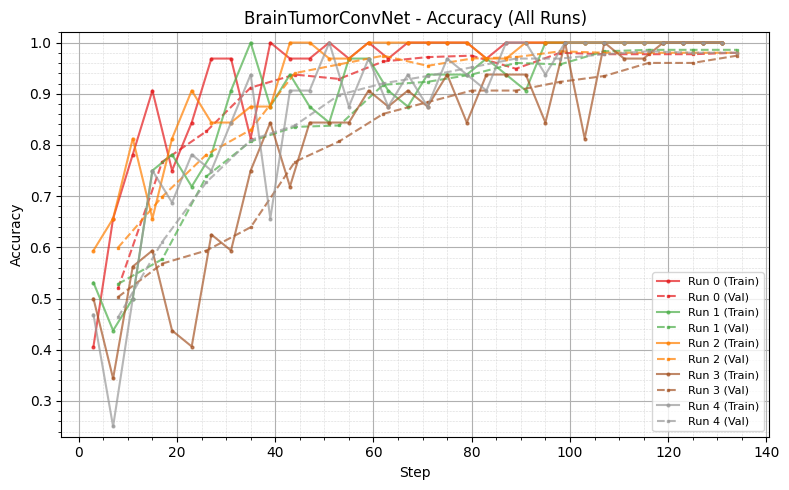

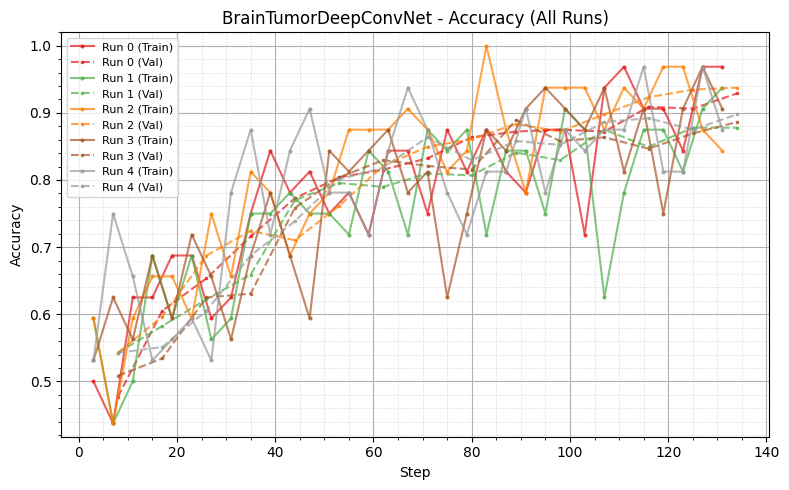

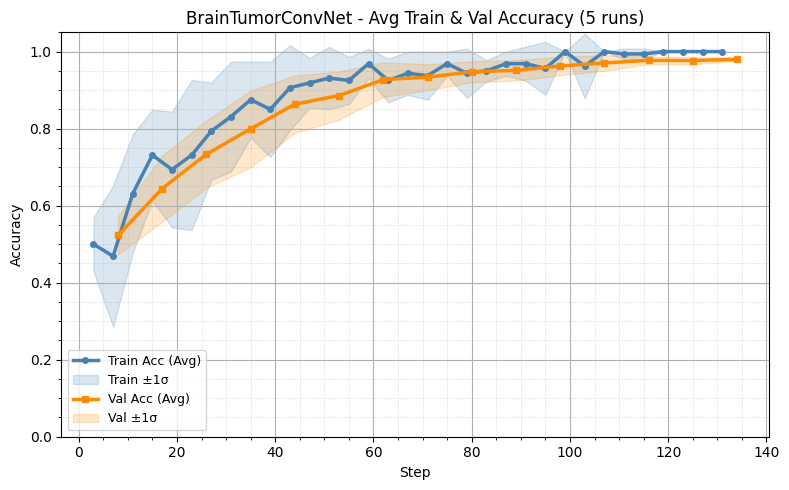

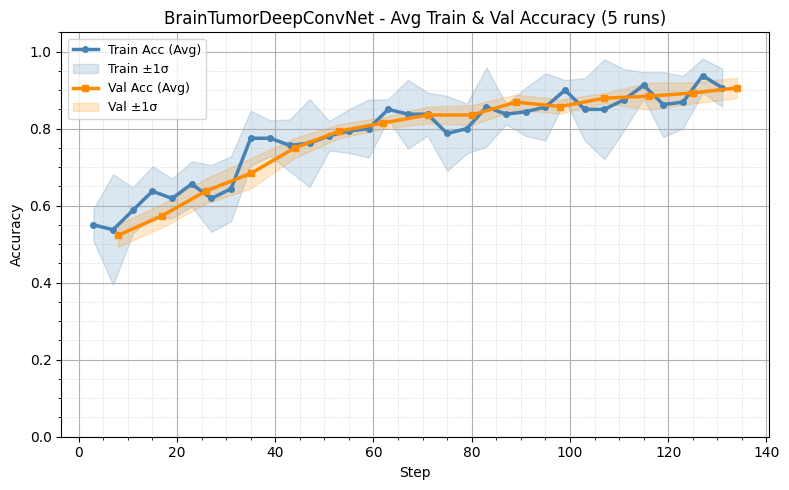

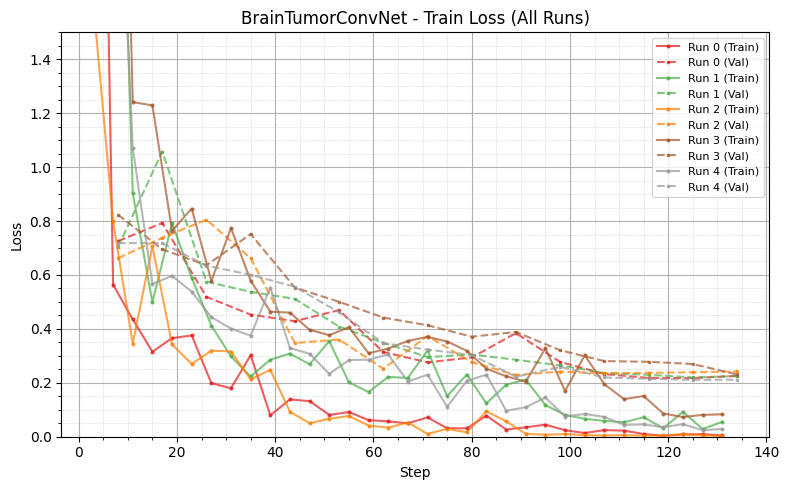

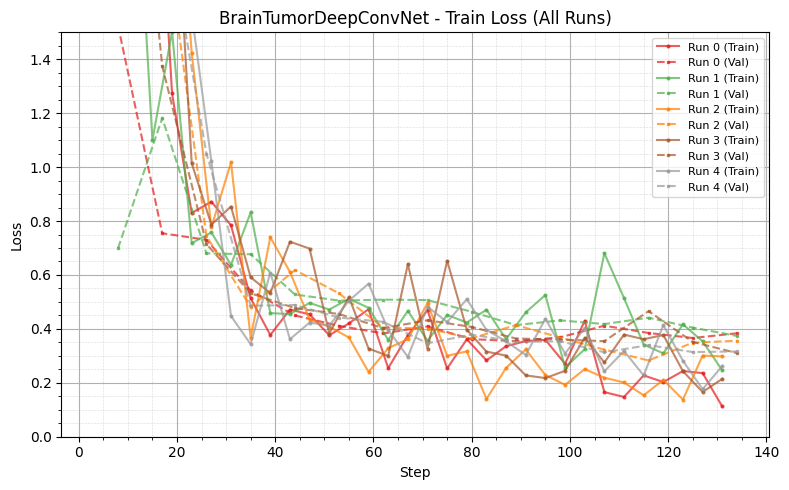

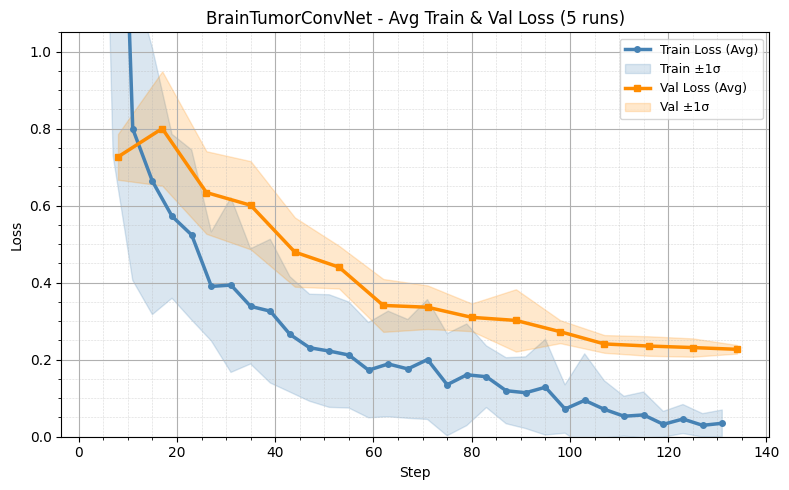

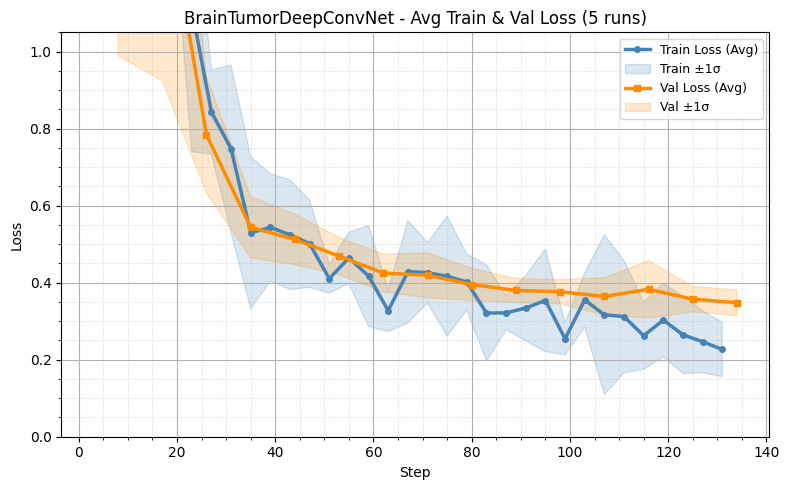

In [10]:
plot_all_runs_acc("BrainTumorConvNet")
plot_all_runs_acc("BrainTumorDeepConvNet")

plot_accuracies_overlap("BrainTumorConvNet")
plot_accuracies_overlap("BrainTumorDeepConvNet")

plot_all_runs_train_loss("BrainTumorConvNet")
plot_all_runs_train_loss("BrainTumorDeepConvNet")

plot_losses_overlap("BrainTumorConvNet")
plot_losses_overlap("BrainTumorDeepConvNet")


# Results and Interpretation

Across 5 independent runs on small training subsets, both architectures performed well on the brain tumor classification task. Both networks showed increasing training and validation accuracy with decreasing loss, reflecting effective learning of tumor classification. Validation accuracy improved steadily while validation loss decreased consistently, indicating successful learning. Overall, the deeper model (BrainTumorDeepConvNet) achieved slightly higher and more stable validation metrics, suggesting stronger generalization from limited data.

## Baseline Model (BrainTumorConvNet)

The baseline BrainTumorConvNet has fewer layers and parameters, so its forward and backward passes are simpler and the effective hypothesis space is smaller. This lets it rapidly fit dominant, easy-to-learn patterns such as large intensity differences between tumor and background, which produces the sharp early drop in training loss and quick rise in training accuracy.

- Training accuracy increased rapidly and plateaued near the upper range, indicating fast convergence and high capacity to fit the training distribution even with fewer layers.  
- Training loss dropped sharply in early steps and continued to decrease, while validation loss decreased more slowly and flattened, suggesting mild overfitting as training progressed.  
- The relatively narrow confidence bands around the accuracy curves show that performance across the 5 runs was stable despite varying small training splits, but the gap between training and validation curves highlights the limited regularization of this shallower design.

## Deep Model (BrainTumorDeepConvNet)

The BrainTumorDeepConvNet has more convolutional layers and parameters, giving it higher representational capacity to model complex, hierarchical features like edges, shapes, textures, and contextual tissue patterns around a tumor.

- Training and validation accuracy curves increased more gradually but remained closer together, reflecting slower but more controlled convergence and improved alignment between fit and generalization.  
- Validation loss decreased steadily and did not diverge from training loss to the same extent as the baseline, indicating that dropout and additional depth effectively mitigated overfitting on the small dataset.  
- The deeper network is more consistent with tighter variance across runs, implying a more robust representation of subtle tumor shapes, textures, and intensity patterns.  
- Although this model introduces a higher parameter count and thus greater computational cost, the improved validation behavior suggests that the extra layers are productively used for richer feature extraction rather than simply memorizing the training data.  

Dropout prevented the deeper network from relying too heavily on any single feature or pathway. This forces the model to build robust feature representations which is especially important with a smaller dataset of training images. The result is closer training and validation curves, slower but steadier convergence, and less pronounced overfitting compared to the baseline.

## Impact of small dataset

With such a small dataset, both models risk overfitting, but the effect is stronger on architectures without sufficient regularization. The deeper model benefits more because the additional layers can extract subtle tumor morphology and texture cues that appear consistently across patients, and dropout discourages memorizing idiosyncrasies of individual samples. This combination yields higher and more stable validation accuracy across the 10 runs, suggesting that the learned features capture genuine medical imaging structure rather than noise.

## Key Observations

- For this small MRI dataset with complex, fine‑scale structures, simply increasing depth with appropriate regularization led to more reliable validation performance than the shallower baseline.  
- Dropout in the deeper network appears to play a crucial role in controlling overfitting, narrowing the gap between training and validation curves and stabilizing performance across different train/validation splits.  
- Both architectures reached clinically promising accuracy levels, but the DeepConvNet variant provided stronger and more consistent generalization, supporting the idea that carefully designed deeper models are advantageous for medical imaging tasks even under limited data, provided that regularization is explicitly incorporated into the architecture.  
